In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

## Import uniqueInchikey subset (positive ionization mode)

# Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


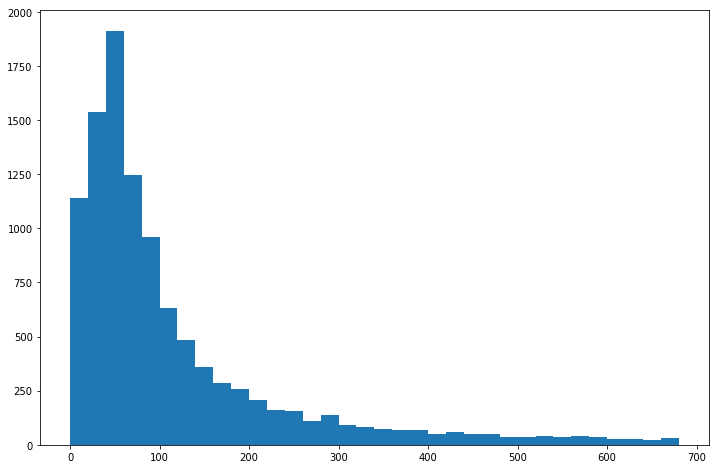

In [4]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,700,20))

# Switch to Spec2Vec core functionality

In [8]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


### Train a Spec2Vec model based on uniqueInchikey subset

In [9]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100_TEMP_15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [10]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.of  10998  documents.2500  of  10998  documents.  of  10998  documents. 10998  documents. of  10998  documents. documents. 10260  of  10998  documents.

### Calculate all-vs-all similarity matrix based on Spec2Vec spectra vectors

In [12]:
from scipy import spatial

# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_library.vectors_centroid, MS_library.vectors_centroid, 'cosine')

In [13]:
#np.save(PATH_SAVE_MODEL + 'M_sim_spec2vec_uI_model_tfidf_191110.npy', M_sim_ctr)
np.save(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uI_model_200219.npy'), M_sim_ctr)

In [37]:
M_sim_ctr = np.load(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uI_model_200219.npy'))

In [14]:
M_sim_ctr.shape

(10998, 10998)

## Compare to model trained on allGNPS_positive

In [16]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_allGNPS_pos_removed0_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [17]:
# Use peak intensities as extra weights
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.0998  documents.10998  documents. 10998  documents.  documents. Calculated centroid vectors for  8550  of  10998  documents. of  10998  documents.  of  10998  documents.

In [18]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_all = 1 - spatial.distance.cdist(MS_library.vectors_centroid, MS_library.vectors_centroid, 'cosine')

In [20]:
np.save(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uI_allGNPS_pos_model_200219.npy'), M_sim_ctr_all)

In [21]:
M_sim_ctr_all.shape

(10998, 10998)

---
# Compare to reference scores based on molecular fingerprints

In [22]:
from plotting_functions import plot_precentile

In [24]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_morgan3_dice2048_191119.npy')
mol_sim_morgan3 = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'dice',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [ ]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
mol_sim_rdkit = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'jaccard',
                                                filename = filename)

In [26]:
# pass on IDs for which fingerprint could not be calculated:
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [27]:
scores = np.delete(np.delete(M_sim_ctr, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = scores.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
scores = np.delete(scores.reshape(length**2), remove_diagonal)

scores_ref = np.delete(np.delete(mol_sim_morgan3, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
scores_ref = np.delete(scores_ref.reshape(length**2), remove_diagonal)

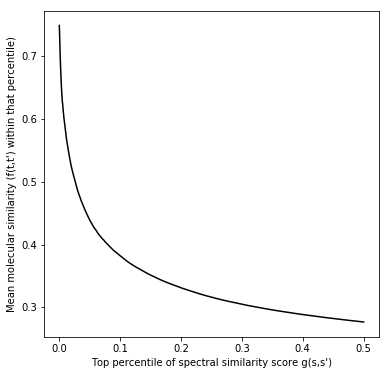

In [28]:
ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice = plot_precentile(scores, scores_ref, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uI-pos_morgan3_2048_dice_200219.npy'), 
        ref_score_Spec2Vec_uniqueInchikey_pos_morgan3_dice)

In [29]:
scores = np.delete(np.delete(M_sim_ctr_all, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = scores.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
scores = np.delete(scores.reshape(length**2), remove_diagonal)

scores_ref = np.delete(np.delete(mol_sim_morgan3, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
scores_ref = np.delete(scores_ref.reshape(length**2), remove_diagonal)

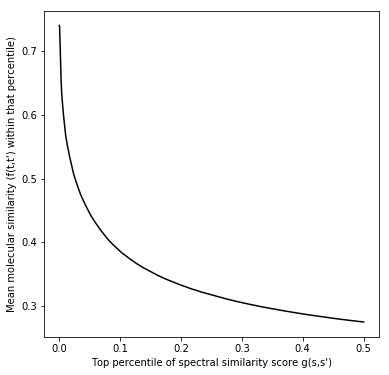

In [31]:
ref_score_Spec2Vec_gnpsALL_pos_morgan3_dice = plot_precentile(scores, scores_ref, num_bins = 1000 , show_top_percentile = 0.5)
np.save(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_gnpsALL-pos_morgan3_2048_dice_200219.npy'), 
        ref_score_Spec2Vec_gnpsALL_pos_morgan3_dice)

# Compare different benchmarks in one graph

In [41]:
#ref_score_best_modcos = np.load(os.path.join(PATH_COMPUTED,'spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy'))
ref_score_best_modcos = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_16.npy'))
ref_score_best_modcos_min_match6 = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_ModCos_min_match_6.npy'))


ref_score_best_cosine = np.load(os.path.join(PATH_COMPUTED,'Benchmarks_uniquesmiles_pos_exp08_filter_Cosine_min_match_6.npy'))

ref_score_S2V_uniqueInchikey = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_uI-pos_morgan3_2048_dice_200219.npy'))
ref_score_S2V_allGNPS = np.load(os.path.join(PATH_COMPUTED, 'ref_score_Spec2Vec_gnpsALL-pos_morgan3_2048_dice_200219.npy'))



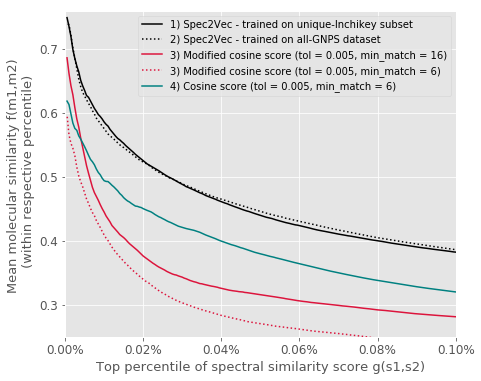

In [69]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_S2V_uniqueInchikey, 
         color='black',
         label='1) Spec2Vec - trained on unique-Inchikey subset')
         #Model: unique_inchikey \n (min_peaks=10, exp filter 0.8, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1],ref_score_S2V_allGNPS, 
         ':', color='black',
         label='2) Spec2Vec - trained on all-GNPS dataset')
         # - Model: allGNPS \n (min_peaks=10, 0.1 perc filter, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_modcos, 
         color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 16)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_modcos_min_match6, 
         ':', color='crimson',
         label='3) Modified cosine score (tol = 0.005, min_match = 6)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_best_cosine, 
         color='teal', #'gold',
         label='4) Cosine score (tol = 0.005, min_match = 6)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_Spec2Vec_uI_allGNPSmodel_pos_morgan3_dice, 
#         '--', color='darkblue',
#         label='Spec2Vec - Model: all GNPS (no retrain) \n (min_peaks=10, 0.1 perc filter, iter=100, dim=300)')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(np.arange(0, 0.11, step=0.02), ('0.00%', '0.02%', '0.04%', '0.06%', '0.08%', '0.10%'))
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.25, 0.76)
plt.savefig('Benchmarking_top_percentil_comparison_200219.pdf')